We've tried to built a deep neural network for our problem. 
The results are really bad for the moment ...

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data

We do the same than our previous notebook called "A bad Simple Linear Regression"

In [4]:
from transplant.tools.learningset import Learningset 

learningset = Learningset ()

X_train, X_test , y_train, y_test , X_col = learningset.get_data_merged_dynamic_flatten("One_Hot",True)
X_train_not_use, X_test_not_use , y_train_cls, y_test_cls , X_col_not_use = learningset.get_data_merged_dynamic_flatten()

Static merged with Flattent Dynamic (i.e. : took the mean for each time serie).
You can chose between One_Hot encoding ([0,1] , [1,0]) with 'One_Hot' for target data or not with 'cls'.
You can chose to center and reduce your data with the train set data with 'True'
Static merged with Flattent Dynamic (i.e. : took the mean for each time serie).
You can chose between One_Hot encoding ([0,1] , [1,0]) with 'One_Hot' for target data or not with 'cls'.
You can chose to center and reduce your data with the train set data with 'True'


In [5]:
from datetime import datetime


now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

## Construction phase

In [6]:
n_inputs = X_train.shape[1]  
n_hidden1 = 35
n_hidden2 = 10
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.shape[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.1

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()


## Run

In [7]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Batch accuracy: 0.48425198 Validation accuracy: 0.43564355
100 Batch accuracy: 0.96062994 Validation accuracy: 0.56435645
200 Batch accuracy: 0.992126 Validation accuracy: 0.5841584
300 Batch accuracy: 0.996063 Validation accuracy: 0.6138614
400 Batch accuracy: 0.996063 Validation accuracy: 0.6039604
500 Batch accuracy: 1.0 Validation accuracy: 0.6039604
600 Batch accuracy: 1.0 Validation accuracy: 0.5940594
700 Batch accuracy: 1.0 Validation accuracy: 0.5940594
800 Batch accuracy: 1.0 Validation accuracy: 0.5841584
900 Batch accuracy: 1.0 Validation accuracy: 0.5841584
Wall time: 5.95 s


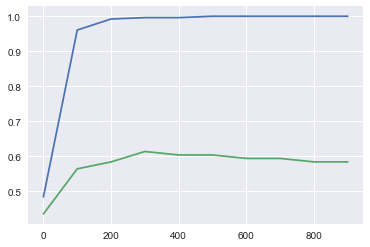

In [8]:
%%time
n_epochs = 1000
batch_size = 150

l_accu=[]
l_batch=[]
l_epoch=[]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train_cls, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_test, y: y_test_cls})
        if epoch%100==0 :
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
            l_epoch+=[epoch]
            l_batch+=[acc_batch]
            l_accu+=[acc_valid]
            
            
plt.plot(l_epoch,l_batch)
plt.plot(l_epoch,l_accu)